In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib.colors import Normalize
%matplotlib inline
import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt
from obspy.signal.util import next_pow_2
import collections

from tqdm import tqdm
import instaseis

def nearest_power_2(x):
    return 2**(x-1).bit_length()


In [48]:
# Normal length
# db = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur005km-00pMS-hQ_hyd30km_2s')
# db_short = 'ice5'
# Long DB
# db = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur020km-00pMS-hQ_hyd30km_5s')
db = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur020km-00pMS-hQ_hyd30km_2s')
db_short = 'ice20'


dist = 20.
rec = instaseis.Receiver(latitude=90 - dist, longitude=0, station='EUR')
#src = instaseis.Source.from_strike_dip_rake(latitude=90, 
#                                            longitude=0, M0=100e13, 
#                                            depth_in_m=5000, strike=123, rake=75, dip=60)
src = instaseis.Source(latitude=90, longitude=0, m_rr=100e13, 
                       depth_in_m=5000)
src.set_sliprate_dirac(dt=db.info.dt, nsamp=100)
print(src)
st = db.get_seismograms(src, rec, components='RTZ', kind='displacement',
                        reconvolve_stf=True, remove_source_shift=False, dt=0.1)

Instaseis Source:
	Origin Time      : 1970-01-01T00:00:00.000000Z
	Longitude        :    0.0 deg
	Latitude         :   90.0 deg
	Depth            : 5.0e+00 km km
	Moment Magnitude :   3.90
	Scalar Moment    :   7.07e+14 Nm
	Mrr              :   1.00e+15 Nm
	Mtt              :   0.00e+00 Nm
	Mpp              :   0.00e+00 Nm
	Mrt              :   0.00e+00 Nm
	Mrp              :   0.00e+00 Nm
	Mtp              :   0.00e+00 Nm



/home/staehler/anaconda3/envs/Py35/lib/python3.5/site-packages/numpy/ma/core.py:3136: ComplexWarning: Casting complex values to real discards the imaginary part
  output = self._data.astype(newtype).view(type(self))


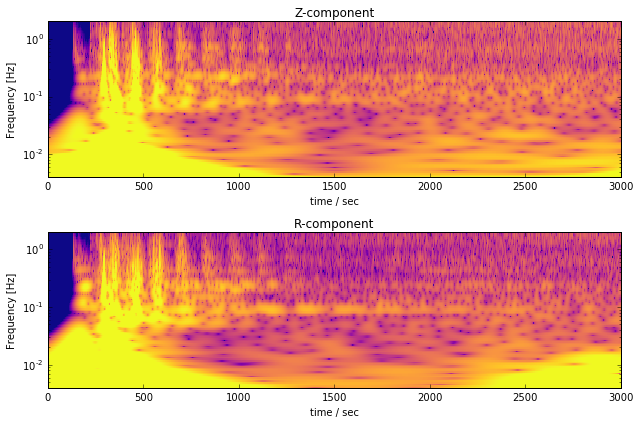

In [49]:
axnum = 210
fig = plt.figure(figsize=(9,6))
for chan in ['Z', 'R']:
    comp = '*%s' % chan
    tr_comb = st.select(channel=comp)[0]

    npts = tr_comb.stats.npts
    dt = tr_comb.stats.delta
    t = np.linspace(0, dt * npts, npts)
    f_min = 1./250
    f_max = 2.

    scalogram = cwt(tr_comb.data, dt, 8, f_min, f_max, nf=100)
   
    axnum += 1
    ax = fig.add_subplot(axnum)

    x, y = np.meshgrid(t,
                       np.logspace(np.log10(f_min), 
                                   np.log10(f_max), 
                                   scalogram.shape[0]))

    m = ax.pcolormesh(x, y, np.log10((scalogram)) * 20., 
                      cmap='plasma',
                      vmin=-200, vmax=-125)
    #ax_cbar = fig.add_axes((0.9, 0.05, 0.04, 0.77))
    #plt.colorbar(mappable=m, cax=ax_cbar)
    ax.set_title('%s-component' % chan)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_yscale('log')
    
    ax.set_ylim(f_min, f_max)
    ax.set_xlim(0,3000)
    ax.set_xlabel('time / sec')
plt.tight_layout()
fig.savefig('spec_M_%03.1f_%03d_deg_%s.png' % (src.moment_magnitude, dist, db_short), dpi=150)
plt.show()

In [22]:
def norm(x):
    return x / np.max(abs(x))

def get_spectrum(db, dists, v_crary=3560, len_psd = 180, len_Crary=400, dt=0.2):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    NFFT = (len_psd / dt)
    NFFT_pad = next_pow_2(NFFT)
    ndists = len(dists)

    ps = np.zeros(NFFT_pad / 2 + 1)
    
    for dist in tqdm(dists):

        dt = 0.2
        ts_crary = dist / 360 * (db.info.planet_radius * 2 * np.pi) / v_crary 
        te_crary = ts_crary + len_Crary
        #print(ts_crary)

        rec = instaseis.Receiver(latitude= 90 - dist, longitude=0, station='EUR')
        src = instaseis.Source.from_strike_dip_rake(latitude=90, 
                                                    longitude=0, M0=100e13, 
                                                    depth_in_m=500, strike=123, rake=75, dip=60)
        src.set_sliprate_dirac(dt=db.info.dt, nsamp=100)

        st = db.get_seismograms(src, rec, components='R', kind='displacement',
                                reconvolve_stf=True, remove_source_shift=False, dt=dt)
        st.trim(starttime=obspy.UTCDateTime(ts_crary), 
                endtime=obspy.UTCDateTime(te_crary))
        tr = st.select(channel='*R')[0]
        ax.plot(tr.times(), norm(tr.data) * 10 + dist)

        p, f = mlab.psd(tr.data, 
                            NFFT=NFFT, Fs=1./dt, noverlap=NFFT*0.8, 
                            pad_to=NFFT_pad, detrend='linear')
        ps += p
        
    return f, ps / ndists

/home/staehler/anaconda3/envs/Py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 18/18 [00:10<00:00,  1.61it/s]


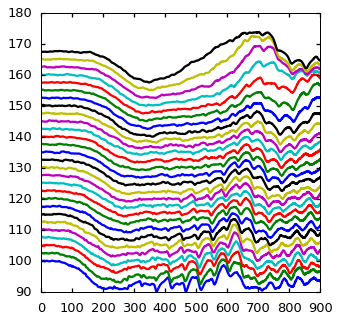

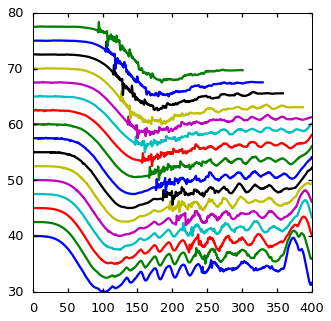

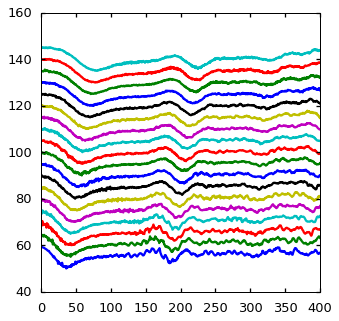

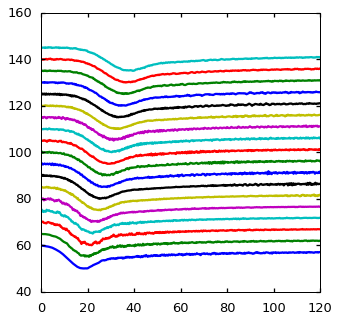

In [124]:
# db = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur005km-00pMS-hQ_hyd30km_2s')
# db_short = 'ice5'
# Long DB
# db = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur020km-00pMS-hQ_hyd30km_5s')
db_20 = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur020km-00pMS-hQ_hyd30km_2s')
db_05 = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur005km-00pMS-hQ_hyd30km_2s')
db_Gany = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Gan126km-00pMS-hQ_hyd30km_2s') #http://instaseis.ethz.ch/icy_ocean_worlds/Tit124km-33pNH-hQ_2s')
db_Titan = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Tit046km-33pNH-hQ_noiceVI_2s')

v_crary = 3560

dists = np.arange(100, 170, 2.5)

f_Gany, p_Gany = get_spectrum(db_Gany, dists, v_crary=3900, 
                                len_psd=500, len_Crary=900)

dists = np.arange(40, 80, 2.5)

f_Titan, p_Titan = get_spectrum(db_Titan, dists, v_crary=3900,
                                len_psd=300, len_Crary=400)

dists = np.arange(60, 150, 5)

f_20, p_20 = get_spectrum(db_20, dists)
f_05, p_05 = get_spectrum(db_05, dists, v_crary=3500, 
                          len_psd=80, len_Crary=120)

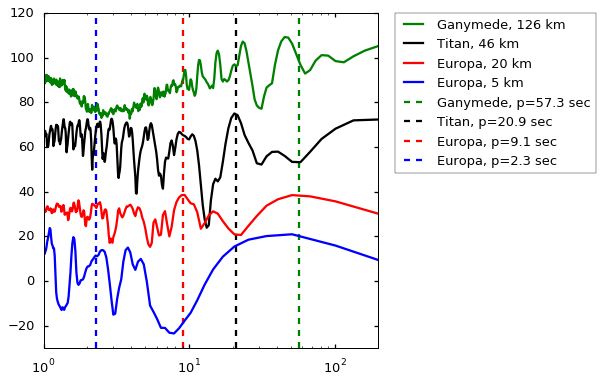

In [136]:
plt.style.use('seaborn-talk')
fig, ax = plt.subplots(1, 1, figsize=(6,6))

x = 1./(f_Gany+1e-4)
y = 10*np.log10(p_Gany/x**2)
ax.plot(x, y - np.mean(y) + 40, 'g', label='Ganymede, 126 km')

x = 1./(f_Titan+1e-4)
y = 10*np.log10(p_Titan/x**2)
ax.plot(x, y - np.mean(y) + 20, 'k', label='Titan, 46 km')

x = 1./(f_20+1e-4)
y = 10*np.log10(p_20/x**2)
ax.plot(x, y - np.mean(y) + 20, 'r', label='Europa, 20 km')

x = 1./(f_05+1e-4)
y = 10*np.log10(p_05/x**2)
ax.plot(x, y - np.mean(y), 'b', label='Europa, 5 km')

ax.vlines(1/0.11 / (20 / 126), -30, 150, 'g', linestyle='dashed', 
          label='Ganymede, p=%3.1f sec' % (1/0.11 / (20 / 126)))

ax.vlines(1/0.11 / (20 / 46), -30, 150, 'k', linestyle='dashed', 
          label='Titan, p=%3.1f sec' % (1/0.11 / (20 / 46)))
ax.vlines(1/0.11, -30, 150, 'r', linestyle='dashed', 
          label='Europa, p=%3.1f sec' % (1/0.11))
ax.vlines(1/0.11 / (20 / 5), -30, 150, 'b', linestyle='dashed', 
          label='Europa, p=%3.1f sec' % (1/0.11 / (20 / 5)))

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlim(1, 200)
ax.set_ylim(-30, 120)
plt.xscale('log')
plt.savefig('Fig_New_Crary_Spectra.pdf')

/home/staehler/anaconda3/envs/Py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


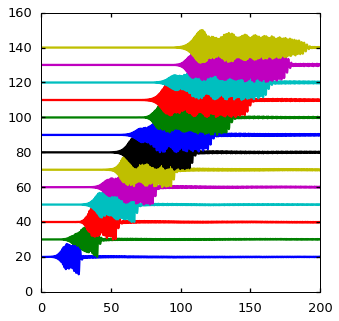

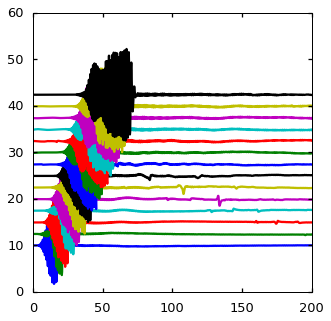

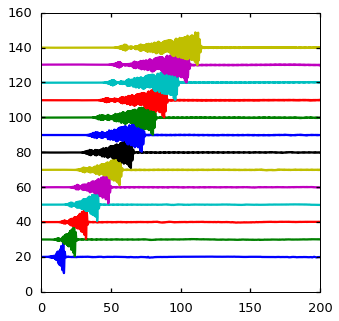

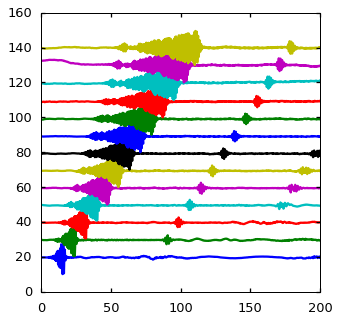

In [80]:
# db = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur005km-00pMS-hQ_hyd30km_2s')
# db_short = 'ice5'
# Long DB
# db = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur020km-00pMS-hQ_hyd30km_5s')
db_20 = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur020km-00pMS-hQ_hyd30km_2s')
db_05 = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur005km-00pMS-hQ_hyd30km_2s')
db_Gany = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Gan126km-00pMS-hQ_hyd30km_2s') #http://instaseis.ethz.ch/icy_ocean_worlds/Tit124km-33pNH-hQ_2s')
db_Titan = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Tit046km-33pNH-hQ_noiceVI_2s')

v_crary = 3560

dists = np.arange(20, 150, 10)
f_Gany, p_Gany = get_spectrum(db_Gany, dists, v_crary=1920, 
                              len_psd=150, len_Crary=200)

dists = np.arange(10, 45, 2.5)
f_Titan, p_Titan = get_spectrum(db_Titan, dists, v_crary=1960,
                                len_psd=150, len_Crary=200)

dists = np.arange(20, 150, 10)
f_20, p_20 = get_spectrum(db_20, dists, v_crary=1940, 
                          len_psd=150, len_Crary=200)
f_05, p_05 = get_spectrum(db_05, dists, v_crary=1940, 
                          len_psd=150, len_Crary=200)

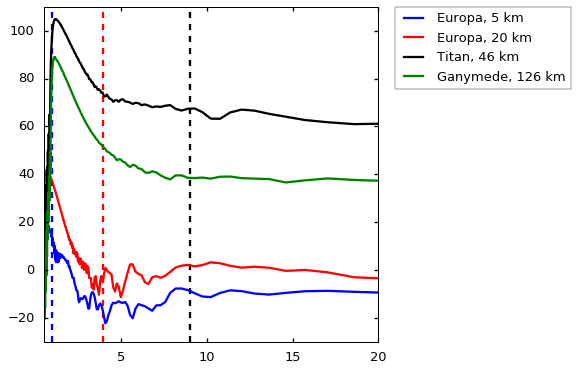

In [86]:
plt.style.use('seaborn-talk')
fig, ax = plt.subplots(1, 1, figsize=(6,6))
x = 1./(f_05+1e-4)
y = 10*np.log10(p_05/x**2)
ax.plot(x, y - np.mean(y), 'b', label='Europa, 5 km')

x = 1./(f_20+1e-4)
y = 10*np.log10(p_20/x**2)
ax.plot(x, y - np.mean(y) + 20, 'r', label='Europa, 20 km')

x = 1./(f_Titan+1e-4)
y = 10*np.log10(p_Titan/x**2)
ax.plot(x, y - np.mean(y) + 50, 'k', label='Titan, 46 km')

x = 1./(f_Gany+1e-4)
y = 10*np.log10(p_Gany/x**2)
ax.plot(x, y - np.mean(y) + 30, 'g', label='Ganymede, 126 km')

ax.vlines(np.pi*20/16, -30, 110, 'r', linestyle='dashed')
ax.vlines(np.pi*5/16, -30, 110, 'b', linestyle='dashed')
ax.vlines(np.pi*46/16, -30, 110, 'k', linestyle='dashed')
ax.vlines(np.pi*126/16, -30, 110, 'g', linestyle='dashed')

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlim(0.5, 20)
ax.set_ylim(-30, 110)
plt.xscale('linear')
plt.show()

(array([ 5.64744099,  1.27087813]), array([[ 1.45241388, -0.19606427],
       [-0.19606427,  0.02891915]]))
[ 0.22        0.125       0.08695652  0.06349206]


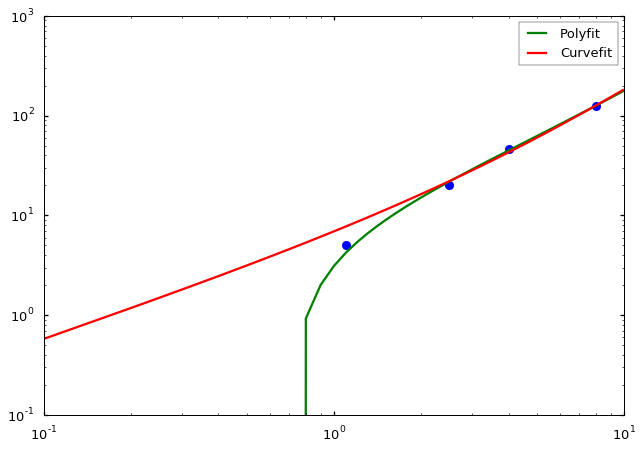

In [117]:
def sq(x, a1, a2):
    return x*a1 + x*x*a2

from scipy.optimize import curve_fit

x = [1.1, 2.5, 4, 8]
y = [5, 20, 46, 126]
plt.plot(x, y, 'o')
plt.xscale('log')
plt.yscale('log')
a = np.polyfit(x, y, deg=2)

a1 = curve_fit(sq, x, y)
print(a1)
print(np.array(x)/np.array(y))
xs = np.arange(0, 10, 0.1)
plt.plot(xs, xs**2*a[0] + xs*a[1] + a[2], label='Polyfit')
plt.plot(xs, xs**2*a1[0][1] + xs*a1[0][0], label='Curvefit')
plt.legend()
plt.show()

/Users/panning/anaconda/envs/obspy3/lib/python3.6/site-packages/numpy/ma/core.py:3194: ComplexWarning: Casting complex values to real discards the imaginary part
  output = self._data.astype(newtype).view(type(self))


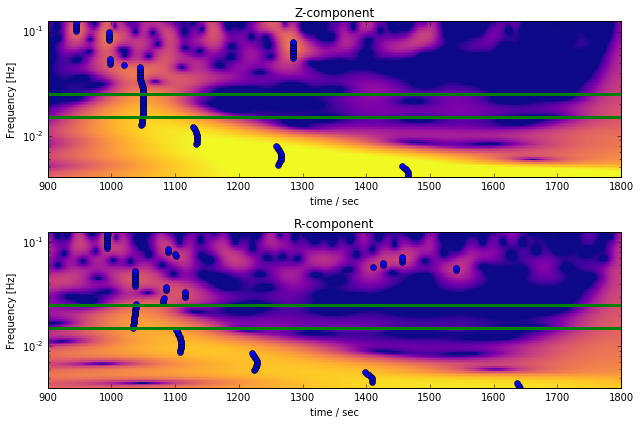

In [12]:
# Redo with data cut for flexural wave window and pick max values as function of frequency
t0 = 900.0
t1 = 1800.0
axnum = 210
fig2 = plt.figure(figsize=(9,6))
for chan in ['Z', 'R']:
    comp = '*%s' % chan
    tr_comb = st.select(channel=comp)[0]

    npts = tr_comb.stats.npts
    dt = tr_comb.stats.delta
    t = np.linspace(0, dt * npts, npts)
    mask = np.logical_and(t > t0, t < t1)
    tmask = t[mask]
    data = tr_comb.data[mask]
    f_min = 1./250
    f_max = 1./8
    f = np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0])

    scalogram = cwt(data, dt, 6, f_min, f_max, nf=100)
   
    axnum += 1
    ax = fig2.add_subplot(axnum)

    x, y = np.meshgrid(tmask, f)

    m = ax.pcolormesh(x, y, np.log10((scalogram)) * 15., 
                      cmap='plasma',
                      vmin=-105, vmax=-77.5)
    #ax_cbar = fig.add_axes((0.9, 0.05, 0.04, 0.77))
    #plt.colorbar(mappable=m, cax=ax_cbar)
    
    # Pick timing of peak values and plot
    tmax = tmask[scalogram.argmax(axis=1)]
    ax.plot(tmax,f,'bo')
    
    ax.set_title('%s-component' % chan)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_yscale('log')
    
    ax.set_ylim(f_min, f_max)
    ax.set_xlim(t0,t1)
    ax.set_xlabel('time / sec')
    
    # Add in lines around approximate group velocity max'
    maxf1 = 0.015
    maxf2 = 0.025
    ax.axhline(y=maxf1, color='g', linestyle='-', linewidth=3)
    ax.axhline(y=maxf2, color='g', linestyle='-', linewidth=3)

plt.tight_layout()
fig.savefig('spec_flexural_M_%03.1f_%03d_deg_%s.png' % (src.moment_magnitude, dist, db_short), dpi=150)
plt.show()

/Users/panning/anaconda/envs/obspy3/lib/python3.6/site-packages/numpy/ma/core.py:3194: ComplexWarning: Casting complex values to real discards the imaginary part
  output = self._data.astype(newtype).view(type(self))


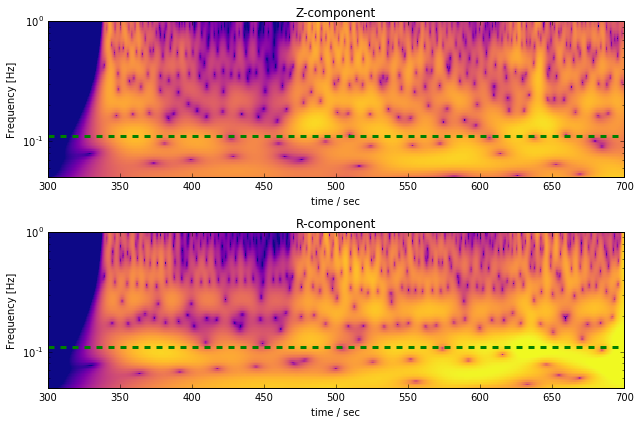

In [13]:
# Zoom in on Crary wave window now
t0 = 300.0
t1 = 700.0
axnum = 210
fig3 = plt.figure(figsize=(9,6))
for chan in ['Z', 'R']:
    comp = '*%s' % chan
    tr_comb = st.select(channel=comp)[0]

    npts = tr_comb.stats.npts
    dt = tr_comb.stats.delta
    t = np.linspace(0, dt * npts, npts)
    mask = np.logical_and(t > t0, t < t1)
    tmask = t[mask]
    data = tr_comb.data[mask]
    f_min = 1./20
    f_max = 1.
    f = np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0])

    scalogram = cwt(data, dt, 6, f_min, f_max, nf=100)
   
    axnum += 1
    ax = fig3.add_subplot(axnum)

    x, y = np.meshgrid(tmask, f)

    m = ax.pcolormesh(x, y, np.log10((scalogram)) * 15., 
                      cmap='plasma',
                      vmin=-150, vmax=-100)
    #ax_cbar = fig.add_axes((0.9, 0.05, 0.04, 0.77))
    #plt.colorbar(mappable=m, cax=ax_cbar)
    
    ax.set_title('%s-component' % chan)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_yscale('log')
    
    ax.set_ylim(f_min, f_max)
    ax.set_xlim(t0,t1)
    ax.set_xlabel('time / sec')
    
        # Add in a line at predicted Crary wave frequency
    f_crary = 0.11
    ax.axhline(y=f_crary, color='g', linestyle='--', linewidth=3)

plt.tight_layout()
fig.savefig('spec_crary_M_%03.1f_%03d_deg_%s.png' % (src.moment_magnitude, dist, db_short), dpi=150)
plt.show()